In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import netCDF4 as nc
import os
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
from netCDF4 import Dataset
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw
import sklearn.cluster as cluster
import seaborn as sns
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.arange(180,350)
x_wcvi_slice = np.arange(480,650)


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry'][:]

lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]

z0 = np.ma.masked_values(Z, 0)

In [3]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

sal_mean_august  = np.mean(sal[88:119,...], axis=0)
temp_mean_august = np.mean(sal[88:119,...], axis=0)
spic_mean_august = np.mean(spic[88:119,...], axis=0)
rho_mean_august  = np.mean(rho[88:119,...], axis=0)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


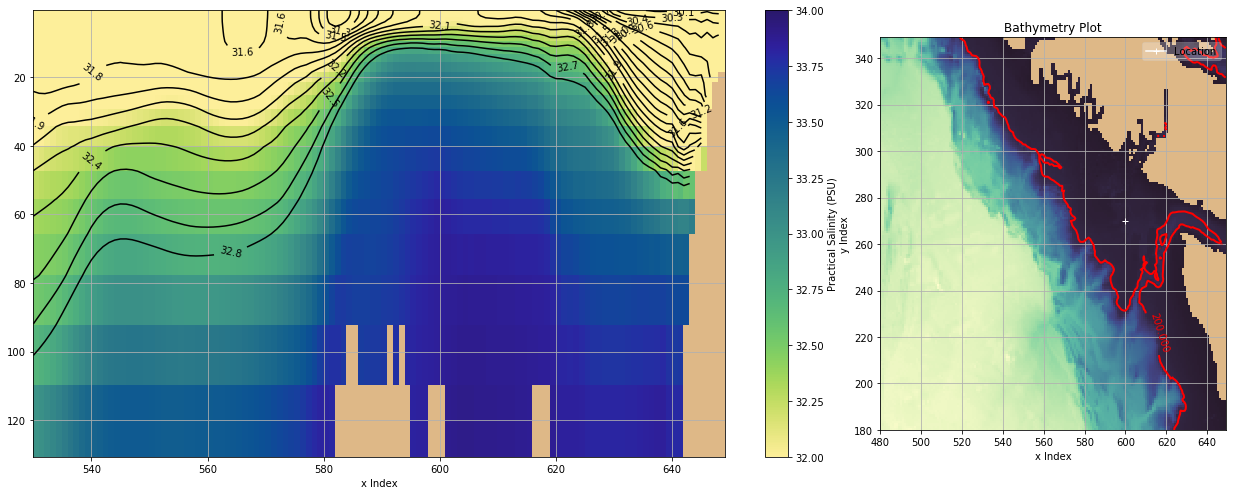

In [84]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.76, 0.125, 0.02, 0.775))
axr.set_position((0.86, 0.125, 0.3, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    600, 270,
    linestyle='-', marker='+', color='white',
    label='Location',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
# sal_0 = sal_july[t, :20, :,:]
sal_0 = sal_mean_august[:24,:,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:24])
mesh = axl.pcolormesh(x_wcvi_slice[50:], zlevels[:24], sal_tzyx[:24,90,50:], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity (PSU)')
clines = axl.contour(x_wcvi_slice[50:], zlevels[:24], sal_tzyx[:24,90,50:], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


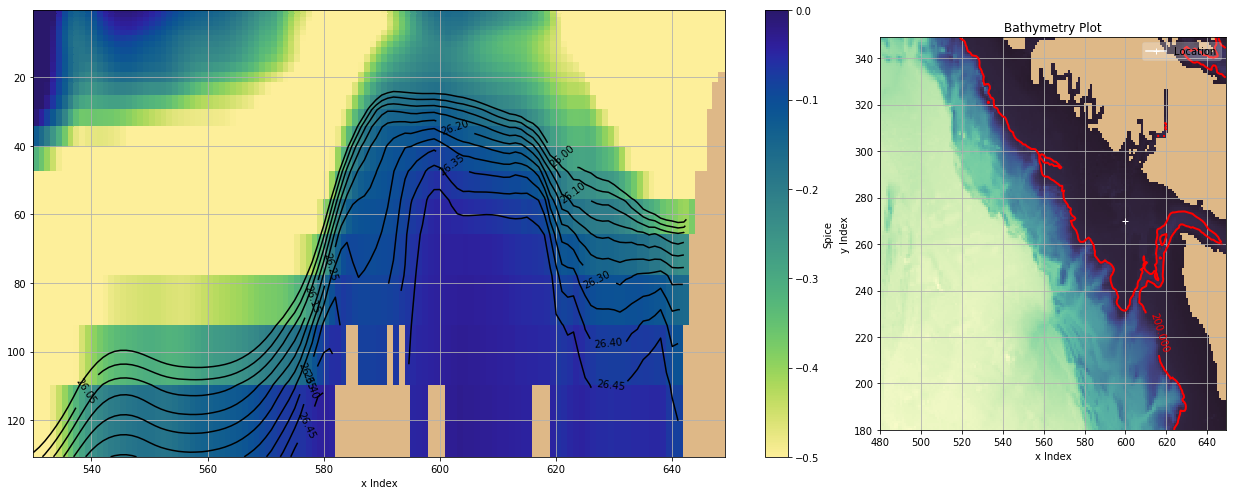

In [85]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.76, 0.125, 0.02, 0.775))
axr.set_position((0.86, 0.125, 0.3, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    600, 270,
    linestyle='-', marker='+', color='white',
    label='Location',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
# sal_0 = sal_july[t, :20, :,:]
spic_0 = spic_mean_august[:24,:,:]
spic_tzyx = np.ma.array(spic_0, mask = np.logical_not(sal_tzyx))


mesh = axl.pcolormesh(x_wcvi_slice[50:], zlevels[:24], spic_tzyx[:24,90,50:], cmap=cmap, vmin=-0.5, vmax =0)#, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Spice')

rho_0 = rho_mean_august[:24,:,:]-1000
rho_tzyx = np.ma.array(rho_0, mask = np.logical_not(sal_tzyx))
# rho_tzyx = np.ma.masked_values(rho_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:24])

clines = axl.contour(x_wcvi_slice[50:], zlevels[:24], rho_tzyx[:24,90,50:], np.arange(26, 26.5, 0.05), colors='black')
axl.clabel(clines, fmt='%1.2f', inline=True)
axl.invert_yaxis()

axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


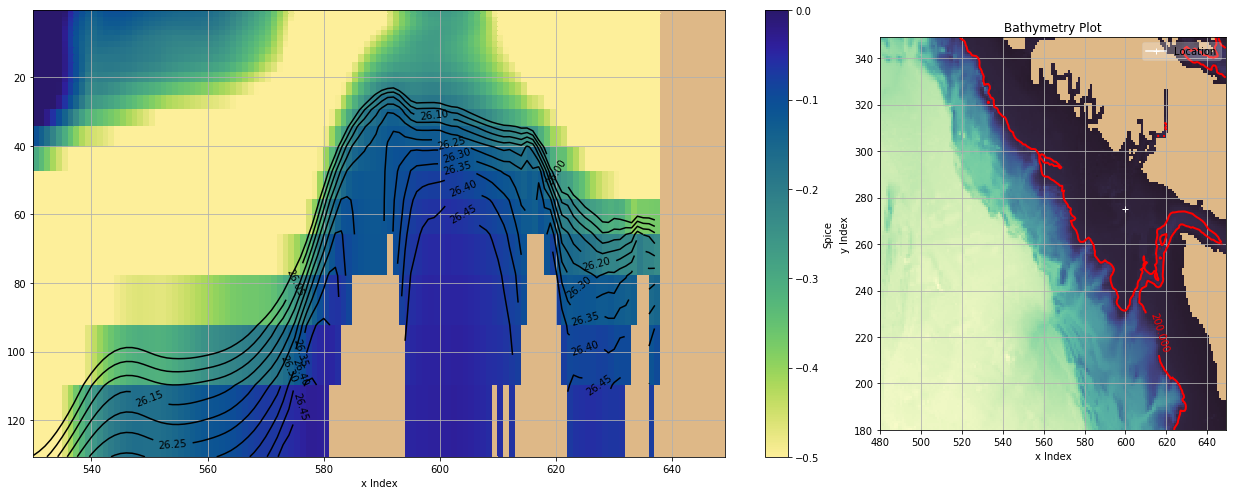

In [86]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.76, 0.125, 0.02, 0.775))
axr.set_position((0.86, 0.125, 0.3, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    600, 275,
    linestyle='-', marker='+', color='white',
    label='Location',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()


cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
# sal_0 = sal_july[t, :20, :,:]
spic_0 = spic_mean_august[:24,:,:]
spic_tzyx = np.ma.array(spic_0, mask = np.logical_not(sal_tzyx))


mesh = axl.pcolormesh(x_wcvi_slice[50:], zlevels[:24], spic_tzyx[:24,95,50:], cmap=cmap, vmin=-0.5, vmax =0)#, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Spice')

rho_0 = rho_mean_august[:24,:,:]-1000
rho_tzyx = np.ma.array(rho_0, mask = np.logical_not(sal_tzyx))
# rho_tzyx = np.ma.masked_values(rho_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:24])

clines = axl.contour(x_wcvi_slice[50:], zlevels[:24], rho_tzyx[:24,95,50:], np.arange(26, 26.5, 0.05), colors='black')
axl.clabel(clines, fmt='%1.2f', inline=True)
axl.invert_yaxis()

axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

In [8]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')
mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][180:350,480:650]
lat = bathy['nav_lat'][180:350,480:650]



In [11]:
iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')


iso_spic = iso_NEP.variables['spiciness'][...];#[:,:,40:100,110:]
isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [8]:
iso_spic.shape

(180, 7, 170, 170)

In [3]:
def add_model_MVP_data(survey_file, iso_level, survey_iso_spic, model_spic):
    
    mat = loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350,480:650]
    lat = bathy['nav_lat'][180:350,480:650]


    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]

    spic_rho_finite = spic_rho_finite[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)
    
    

    model_spic = np.append(arr= model_spic, values=model_add)
    
    return survey_iso_spic, model_spic

def calcuate_location_of_kde_custers_kmeans_5(survey_file, iso_level, survey_iso_spic, model_spic, y_added_1,x_added_1):#,\
#                                     y_added_2,x_added_2,y_added_3,x_added_3, y_added_4,x_added_4,\
#                                              y_added_5,x_added_5):
    
    mat = loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350,480:650]
    lat = bathy['nav_lat'][180:350,480:650]


    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite1 = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]
        



    
    df =pd.DataFrame()
    df['Observed Spice'] = spic_rho_finite1[~np.isnan(model_add)]
    df['Model Spice'] = model_add[~np.isnan(model_add)]
    
    y = y[~np.isnan(model_add)]
    x = x[~np.isnan(model_add)]
    
    spic_rho_finite = spic_rho_finite1[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)    

    model_spic = np.append(arr= model_spic, values=model_add)
    

    
#     def plot_clusters(data, algorithm, args, kwds):
# #         start_time = time.time()
#         labels = algorithm(*args, **kwds).fit_predict(data)
# #         end_time = time.time()
# #         palette = sns.color_palette('deep', np.unique(labels).max() + 1)
# #         colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
# #         plt.scatter(survey_iso_spic, model_spic, c=colors, **plot_kwds)
#         return labels
    
#     labels = plot_clusters(df, cluster.KMeans, (), {'n_clusters':5})
    
    y_1 = y[:]
    x_1 = x[:]
    
#     y_264_cluster_2 = y[labels == 1]
#     x_264_cluster_2 = x[labels == 1]
    
#     y_264_cluster_3 = y[labels == 2]
#     x_264_cluster_3 = x[labels == 2]
    
#     y_264_cluster_4 = y[labels == 3]
#     x_264_cluster_4 = x[labels == 3]
    
#     y_264_cluster_5 = y[labels == 4]
#     x_264_cluster_5 = x[labels == 4]
    
    
#     y_264_cluster_1 = y[spic_rho_finite1<=-0.21]
#     x_264_cluster_1 = x[spic_rho_finite1<=-0.21]
    
#     y_264_cluster_2 = y[(spic_rho_finite1<-0.10) & (spic_rho_finite1> -0.16)]
#     x_264_cluster_2 = x[(spic_rho_finite1<-0.10) & (spic_rho_finite1> -0.16)]
    
#     y_264_cluster_3 = y[spic_rho_finite1>=-0.10]
#     x_264_cluster_3 = x[spic_rho_finite1>=-0.10]
    
    y_added_1 = np.append(arr= y_added_1,  values= y_1)
    x_added_1 = np.append(arr= x_added_1,  values= x_1)
    
#     y_added_2 = np.append(arr= y_added_2,  values= y_264_cluster_2)
#     x_added_2 = np.append(arr= x_added_2,  values= x_264_cluster_2)
    
#     y_added_3 = np.append(arr= y_added_3,  values= y_264_cluster_3)
#     x_added_3 = np.append(arr= x_added_3,  values= x_264_cluster_3)
    
#     y_added_4 = np.append(arr= y_added_4,  values= y_264_cluster_4)
#     x_added_4 = np.append(arr= x_added_4,  values= x_264_cluster_4)
    
#     y_added_5 = np.append(arr= y_added_5,  values= y_264_cluster_5)
#     x_added_5 = np.append(arr= x_added_5,  values= x_264_cluster_5)

    
    return survey_iso_spic, model_spic, y_added_1, x_added_1#, y_added_2, x_added_2, y_added_3, x_added_3, y_added_4, x_added_4, \
# y_added_5, x_added_5

def plot_clusters(ax, data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    ax.scatter(survey_iso_spic, model_spic, c=colors, **plot_kwds)
    return labels, colors
#     frame = plt.gca()
#     frame.axes.get_xaxis().set_visible(False)
#     frame.axes.get_yaxis().set_visible(False)
#     plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
#     plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)




In [4]:
survey_mat_file_A = '/data/ssahu/Falkor_2013/mvp/surveyA.mat'
survey_mat_file_B = '/data/ssahu/Falkor_2013/mvp/surveyB.mat'
survey_mat_file_D = '/data/ssahu/Falkor_2013/mvp/surveyD.mat'
survey_mat_file_E = '/data/ssahu/Falkor_2013/mvp/surveyE.mat'
survey_mat_file_G = '/data/ssahu/Falkor_2013/mvp/surveyG.mat'


all_surveys = [survey_mat_file_A, survey_mat_file_B, survey_mat_file_D, \
              survey_mat_file_E, survey_mat_file_G]

### On 26.4 isopycnal

In [4]:
sns.set_style('darkgrid')

In [11]:
model_spic = []
survey_iso_spic = []

survey_iso_spic_A, model_spic_A = add_model_MVP_data(survey_file=survey_mat_file_A, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_B, model_spic_B = add_model_MVP_data(survey_file=survey_mat_file_B, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_D, model_spic_D = add_model_MVP_data(survey_file=survey_mat_file_D, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_E, model_spic_E = add_model_MVP_data(survey_file=survey_mat_file_E, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_G, model_spic_G = add_model_MVP_data(survey_file=survey_mat_file_G, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)


    
    
model_spic = []
survey_iso_spic = []

y_added_1 = []
x_added_1 = []
# y_added_2 = []
# x_added_2 = []
# y_added_3 = []
# x_added_3 = []
# y_added_4 = []
# x_added_4 = []
# y_added_5 = []
# x_added_5 = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic, y_added_1, x_added_1 \
    = calcuate_location_of_kde_custers_kmeans_5(survey_file=survey_file, \
                                                iso_level=4,model_spic=model_spic, \
                                                survey_iso_spic=survey_iso_spic,y_added_1=y_added_1,x_added_1=x_added_1)#,\
#                                                 y_added_2=y_added_2,x_added_2=x_added_2,y_added_3=y_added_3,x_added_3=x_added_3,\
#                                                y_added_4=y_added_4,x_added_4=x_added_4, \
#                                                y_added_5=y_added_5,x_added_5=x_added_5)

(560, 640)

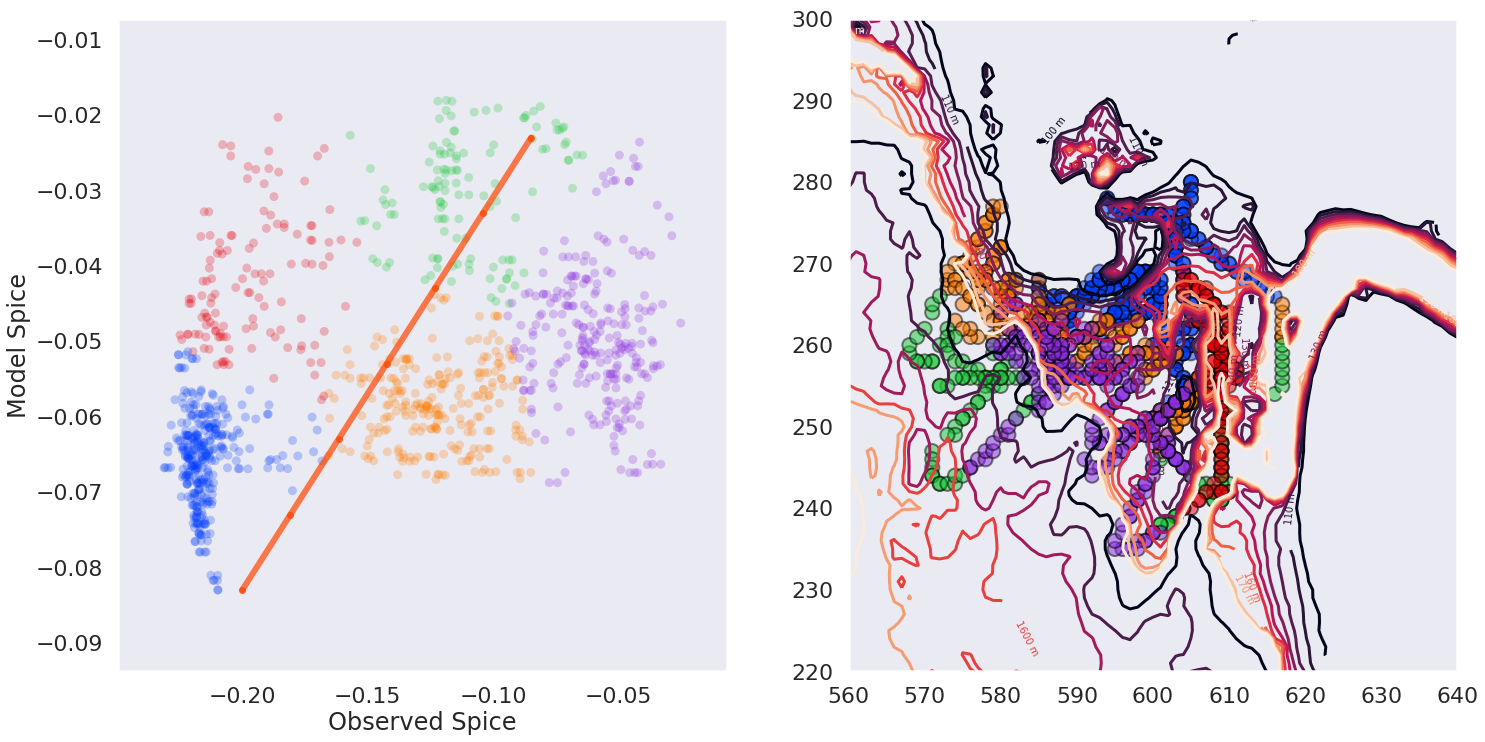

In [12]:
df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# >>> def func(x, a, b, c):
# #     return a * np.exp(-b * x) + c

# calculate polynomial
z = np.polyfit(df['Model Spice'],df['Observed Spice'], 1)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.arange(np.min(df['Model Spice']), np.max(df['Model Spice']), 0.01)
y_new = f(x_new)

x_fit = df['Model Spice']
y_fit = f(x_fit)


df['Fitted Spice'] = y_fit




fig, (ax1,ax) = plt.subplots(1,2, figsize=(24,12))

# q = plot_clusters(df, cluster.KMeans, (), {'n_clusters':3})

labels, colors = plot_clusters(ax=ax1, data=df, algorithm=cluster.KMeans, args=(), kwds={'n_clusters':5})
colors = np.array(colors)
ax1.set_xlabel("Observed Spice")
ax1.set_ylabel("Model Spice")

ax1.plot(y_new, x_new, lw=6, c='orangered', marker='.', alpha=0.7)

# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Fitted Spice'])
# anchored_text = AnchoredText("Statistics with Fitted Line: Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0., 1.),
#                        bbox_transform=ax1.transAxes
#                        )
# ax1.add_artist(anchored_text)


# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0.32, 0.),
#                        bbox_transform=ax1.transAxes
#                        )
# ax1.add_artist(anchored_text)

# ax.axhline(y=-0.055, c = 'teal')
# ax.axvline(x= -0.17, c = 'teal')

# ax.axhline(y=-0.037, c = 'red')


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# cmap = plt.get_cmap('deep')
# cmap = sns.color_palette('bright', np.unique(labels).max() + 1)
#     cmap.set_bad('burlywood')
# cmap.set_bad('#8b7765')
# fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

# for i in np.arange(x_added_3.shape[0]):

#     ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



y_264_cluster_1 = y_added_1[labels == 0]
x_264_cluster_1 = x_added_1[labels == 0]

y_264_cluster_2 = y_added_1[labels == 1]
x_264_cluster_2 = x_added_1[labels == 1]

y_264_cluster_3 = y_added_1[labels == 2]
x_264_cluster_3 = x_added_1[labels == 2]

y_264_cluster_4 = y_added_1[labels == 3]
x_264_cluster_4 = x_added_1[labels == 3]

y_264_cluster_5 = y_added_1[labels == 4]
x_264_cluster_5 = x_added_1[labels == 4]


for i in np.arange(x_264_cluster_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_1[i])], y_wcvi_slice[np.int(y_264_cluster_1[i])], c = colors[labels == 0], alpha= 0.5, s=200, edgecolor= 'black', label = 'cluster 1')

for i in np.arange(x_264_cluster_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_2[i])], y_wcvi_slice[np.int(y_264_cluster_2[i])], c = colors[labels == 1], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 2')

for i in np.arange(x_264_cluster_3.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_3[i])], y_wcvi_slice[np.int(y_264_cluster_3[i])], c = colors[labels == 2], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 3')

for i in np.arange(x_264_cluster_4.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_4[i])], y_wcvi_slice[np.int(y_264_cluster_4[i])], c = colors[labels == 3], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 4')

for i in np.arange(x_264_cluster_5.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_5[i])], y_wcvi_slice[np.int(y_264_cluster_5[i])], c = colors[labels == 4], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 5')

ax.set_ylim(220,300)
ax.set_xlim(560,640)


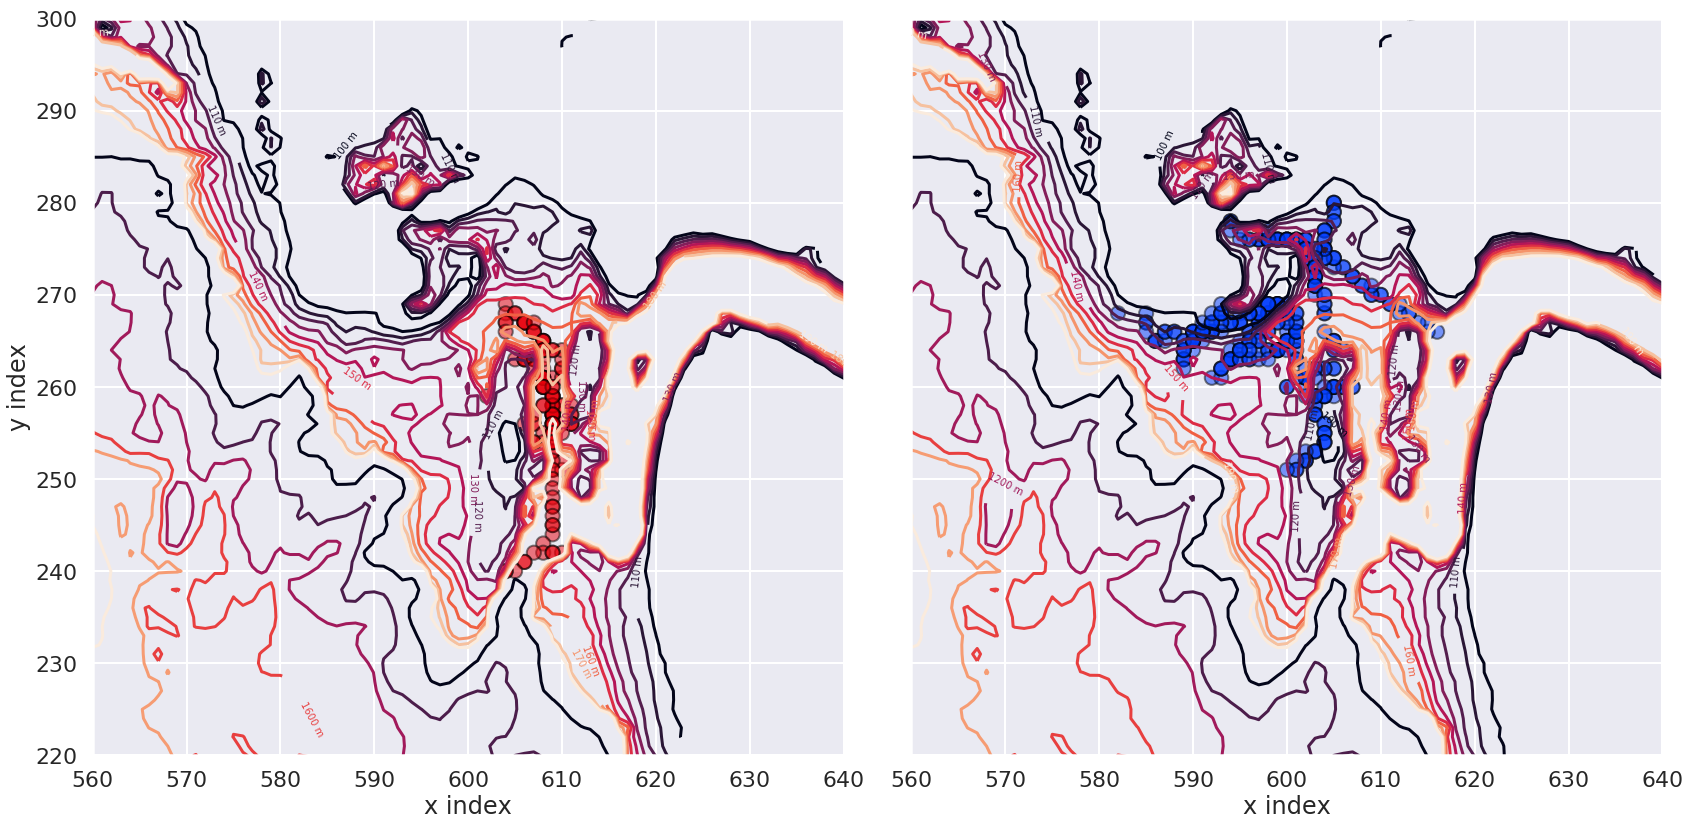

In [15]:


fig, (ax1,ax) = plt.subplots(1,2, figsize=(24,12), sharey=True)




bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))

CS = ax1.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax1.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)




for i in np.arange(x_264_cluster_4.shape[0]):

    ax1.scatter(x_wcvi_slice[np.int(x_264_cluster_4[i])], y_wcvi_slice[np.int(y_264_cluster_4[i])], c = colors[labels == 3], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 5')


ax1.set_ylim(220,300)
ax1.set_xlim(560,640)

ax1.set_ylabel('y index')
ax1.set_xlabel('x index')

ax1.grid()


CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)




for i in np.arange(x_264_cluster_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_1[i])], y_wcvi_slice[np.int(y_264_cluster_1[i])], c = colors[labels == 0], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 2')


ax.set_ylim(220,300)
ax.set_xlim(560,640)

ax.set_xlabel('x index')
ax.grid()

fig.tight_layout()


In [16]:
model_right_cluster_x = x_264_cluster_1
model_right_cluster_y = y_264_cluster_1


model_wrong_cluster_x = x_264_cluster_4
model_wrong_cluster_y = y_264_cluster_4

In [17]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']



In [21]:
rho_0 = 26.4
rho_intialising = rho[119,...] ##we initialise at this time step 26th August 120th day


z_intialising_right, z_intialising_wrong, model_x_right, model_y_right, model_x_wrong, model_y_wrong = \
get_z_indices_for_the_isopycnal_points(model_right_cluster_x=model_right_cluster_x, model_right_cluster_y=model_right_cluster_y,rho_0=rho_0,\
                                       rho_intialising=rho_intialising,model_wrong_cluster_x=model_wrong_cluster_x, \
                                       model_wrong_cluster_y = model_wrong_cluster_y)

In [22]:
init_file = pd.read_csv('/ocean/ssahu/CANYONS/ariane/ariane-2.2.8_04/initial_positions_LB08.txt', delimiter= ' ', header=None)

df =pd.DataFrame(data=init_file)
df = df.iloc[df.shape[0]:]
       
for p in np.arange(model_y_right.shape[0]):
    
    df = df.append({0:model_x_right[p]+1+0.01,1:model_y_right[p]+1+0.01,2:z_intialising_right[p]+1, 3:119.5, 4:1.0}, ignore_index=True)

df.to_csv('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/isopyncal_264/\
right_positions_iso_264.txt',
          sep = ' ', header = None, index=False)

df =pd.DataFrame(data=init_file)
df = df.iloc[df.shape[0]:]
       
for p in np.arange(model_y_wrong.shape[0]):
    
    df = df.append({0:model_x_wrong[p]+1+0.01,1:model_y_wrong[p]+1+0.01,2:z_intialising_wrong[p]+1, 3:119.5, 4:1.0}, ignore_index=True)

df.to_csv('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/isopyncal_264/\
wrong_positions_iso_264.txt',
          sep = ' ', header = None, index=False)

### On the 26.3 isopycnal

In [33]:
model_spic = []
survey_iso_spic = []

survey_iso_spic_A, model_spic_A = add_model_MVP_data(survey_file=survey_mat_file_A, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_B, model_spic_B = add_model_MVP_data(survey_file=survey_mat_file_B, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_D, model_spic_D = add_model_MVP_data(survey_file=survey_mat_file_D, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_E, model_spic_E = add_model_MVP_data(survey_file=survey_mat_file_E, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_G, model_spic_G = add_model_MVP_data(survey_file=survey_mat_file_G, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)


    
    
model_spic = []
survey_iso_spic = []

y_added_1 = []
x_added_1 = []
# y_added_2 = []
# x_added_2 = []
# y_added_3 = []
# x_added_3 = []
# y_added_4 = []
# x_added_4 = []
# y_added_5 = []
# x_added_5 = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic, y_added_1, x_added_1 \
    = calcuate_location_of_kde_custers_kmeans_5(survey_file=survey_file, \
                                                iso_level=3,model_spic=model_spic, \
                                                survey_iso_spic=survey_iso_spic,y_added_1=y_added_1,x_added_1=x_added_1)#,\
#                                                 y_added_2=y_added_2,x_added_2=x_added_2,y_added_3=y_added_3,x_added_3=x_added_3,\
#                                                y_added_4=y_added_4,x_added_4=x_added_4, \
#                                                y_added_5=y_added_5,x_added_5=x_added_5)

(560, 640)

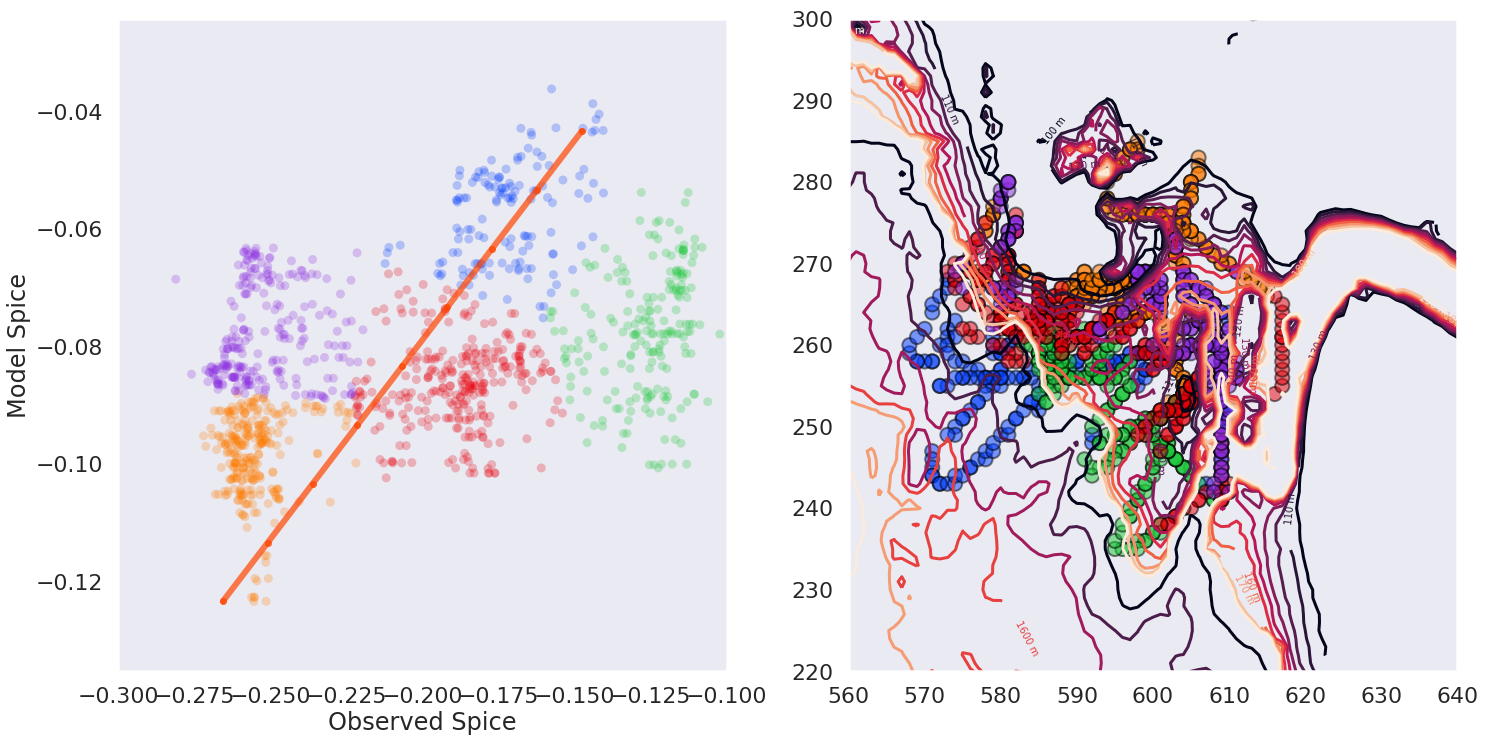

In [34]:
df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# >>> def func(x, a, b, c):
# #     return a * np.exp(-b * x) + c

# calculate polynomial
z = np.polyfit(df['Model Spice'],df['Observed Spice'], 1)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.arange(np.min(df['Model Spice']), np.max(df['Model Spice']), 0.01)
y_new = f(x_new)

x_fit = df['Model Spice']
y_fit = f(x_fit)


df['Fitted Spice'] = y_fit




fig, (ax1,ax) = plt.subplots(1,2, figsize=(24,12))

# q = plot_clusters(df, cluster.KMeans, (), {'n_clusters':3})

labels, colors = plot_clusters(ax=ax1, data=df, algorithm=cluster.KMeans, args=(), kwds={'n_clusters':5})
colors = np.array(colors)
ax1.set_xlabel("Observed Spice")
ax1.set_ylabel("Model Spice")

ax1.plot(y_new, x_new, lw=6, c='orangered', marker='.', alpha=0.7)
ax1.set_xlim(-0.3,-0.1)

# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Fitted Spice'])
# anchored_text = AnchoredText("Statistics with Fitted Line: Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0., 1.),
#                        bbox_transform=ax1.transAxes
#                        )
# ax1.add_artist(anchored_text)


# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0.32, 0.),
#                        bbox_transform=ax1.transAxes
#                        )
# ax1.add_artist(anchored_text)

# ax.axhline(y=-0.055, c = 'teal')
# ax.axvline(x= -0.17, c = 'teal')

# ax.axhline(y=-0.037, c = 'red')


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# cmap = plt.get_cmap('deep')
# cmap = sns.color_palette('bright', np.unique(labels).max() + 1)
#     cmap.set_bad('burlywood')
# cmap.set_bad('#8b7765')
# fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

# for i in np.arange(x_added_3.shape[0]):

#     ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



y_264_cluster_1 = y_added_1[labels == 0]
x_264_cluster_1 = x_added_1[labels == 0]

y_264_cluster_2 = y_added_1[labels == 1]
x_264_cluster_2 = x_added_1[labels == 1]

y_264_cluster_3 = y_added_1[labels == 2]
x_264_cluster_3 = x_added_1[labels == 2]

y_264_cluster_4 = y_added_1[labels == 3]
x_264_cluster_4 = x_added_1[labels == 3]

y_264_cluster_5 = y_added_1[labels == 4]
x_264_cluster_5 = x_added_1[labels == 4]


for i in np.arange(x_264_cluster_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_1[i])], y_wcvi_slice[np.int(y_264_cluster_1[i])], c = colors[labels == 0], alpha= 0.5, s=200, edgecolor= 'black', label = 'cluster 1')

for i in np.arange(x_264_cluster_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_2[i])], y_wcvi_slice[np.int(y_264_cluster_2[i])], c = colors[labels == 1], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 2')

for i in np.arange(x_264_cluster_3.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_3[i])], y_wcvi_slice[np.int(y_264_cluster_3[i])], c = colors[labels == 2], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 3')

for i in np.arange(x_264_cluster_4.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_4[i])], y_wcvi_slice[np.int(y_264_cluster_4[i])], c = colors[labels == 3], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 4')

for i in np.arange(x_264_cluster_5.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_5[i])], y_wcvi_slice[np.int(y_264_cluster_5[i])], c = colors[labels == 4], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 5')

ax.set_ylim(220,300)
ax.set_xlim(560,640)


In [19]:
np.max(x_264_cluster_1)

print(x_wcvi_slice[np.int(np.max(x_264_cluster_1))])

608


In [30]:
np.max(x_264_cluster_2)

print(x_wcvi_slice[np.int(np.max(x_264_cluster_2))])

617


In [31]:
sns.set_style('dark')

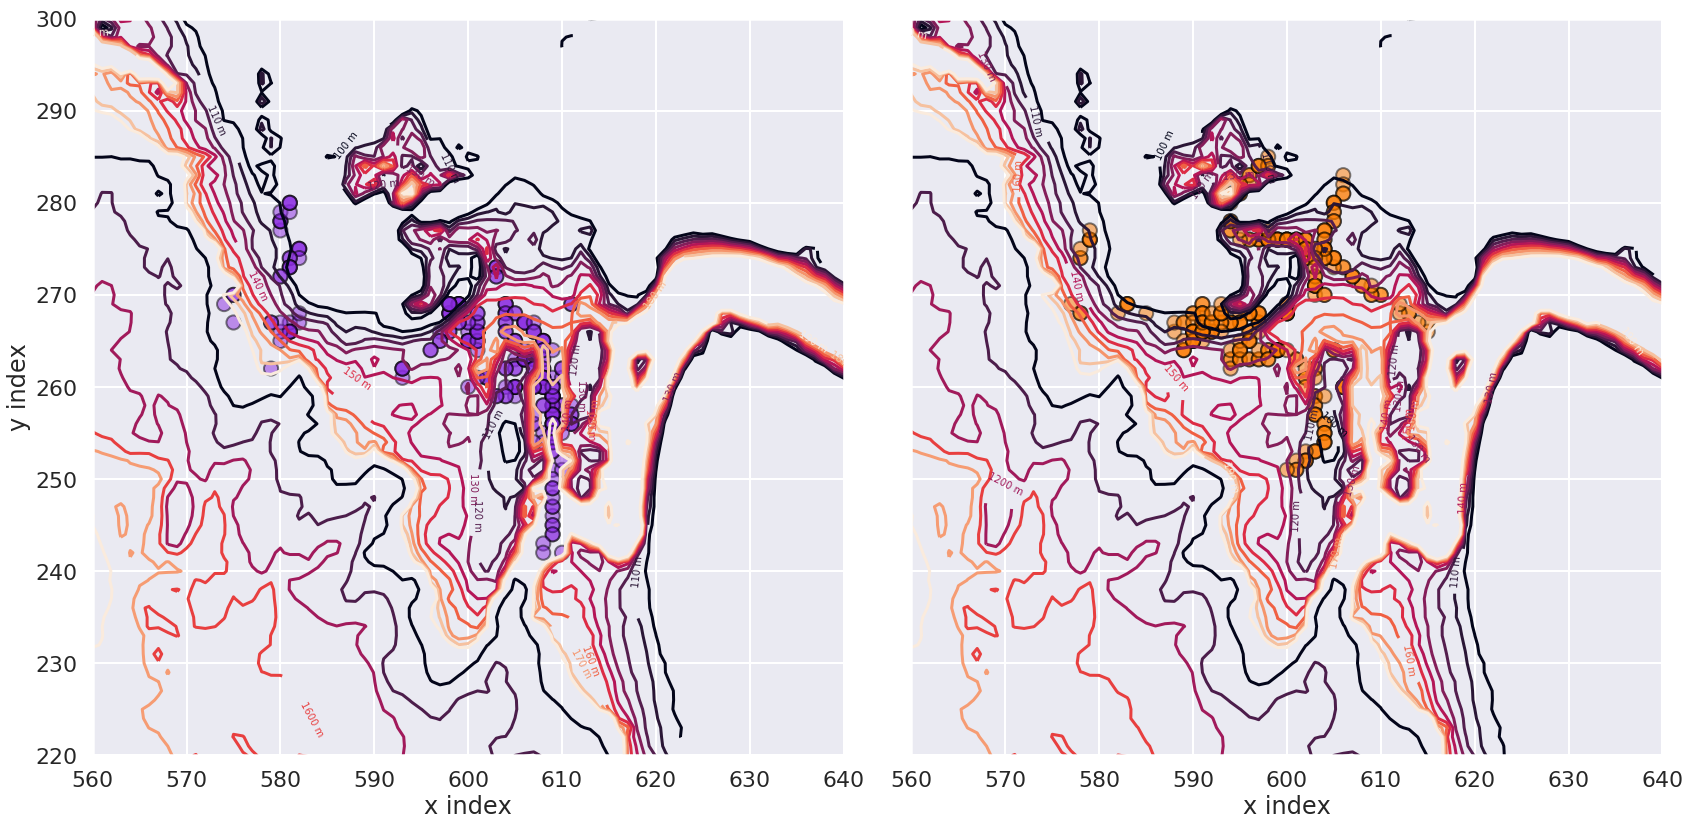

In [38]:


fig, (ax1,ax) = plt.subplots(1,2, figsize=(24,12), sharey=True)




bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))

CS = ax1.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax1.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)




for i in np.arange(x_264_cluster_5.shape[0]):

    ax1.scatter(x_wcvi_slice[np.int(x_264_cluster_5[i])], y_wcvi_slice[np.int(y_264_cluster_5[i])], c = colors[labels == 4], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 5')


ax1.set_ylim(220,300)
ax1.set_xlim(560,640)

ax1.set_ylabel('y index')
ax1.set_xlabel('x index')

ax1.grid()


CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)




for i in np.arange(x_264_cluster_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_2[i])], y_wcvi_slice[np.int(y_264_cluster_2[i])], c = colors[labels == 1], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 2')


ax.set_ylim(220,300)
ax.set_xlim(560,640)

ax.set_xlabel('x index')
ax.grid()

fig.tight_layout()


A point of caution this cluster number changes so always make this plot to see if that number is the same that you expect from the y vs x region of the plot above. Now it's time to write their initial positions in a file for ARIANE; again make sure it is the same cluster that you are writing the positions for

Now we know the model locations of the particles in x and y; we need to figure the depths of the particles so that we can specify the z level; in other words we need to know what the depth of the 26.3 isopycnal was in those locations; we can do for the individual points and not compute the whole curtain

In [48]:
model_right_cluster_x = x_264_cluster_2
model_right_cluster_y = y_264_cluster_2


model_wrong_cluster_x = x_264_cluster_5
model_wrong_cluster_y = y_264_cluster_5

In [6]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

rho_intialising = rho[119,...]

rho_intialising.shape

(32, 170, 170)

In [5]:
def get_z_indices_for_the_isopycnal_points(rho_0, rho_intialising, model_right_cluster_x, model_right_cluster_y, \
                                           model_wrong_cluster_x, model_wrong_cluster_y):

    model_x_right = []
    model_y_right = []

    for j in np.arange(model_right_cluster_x.shape[0]):
        if x_wcvi_slice[np.int(model_right_cluster_x[j])] > 590:
            model_x_right = np.append(arr=model_x_right, values=np.int(model_right_cluster_x[j]))
            model_y_right = np.append(arr=model_y_right, values=np.int(model_right_cluster_y[j]))

    model_x_wrong = []
    model_y_wrong = []

    for j in np.arange(model_wrong_cluster_x.shape[0]):
        if x_wcvi_slice[np.int(model_wrong_cluster_x[j])] > 590:
            model_x_wrong = np.append(arr=model_x_wrong, values=np.int(model_wrong_cluster_x[j]))
            model_y_wrong = np.append(arr=model_y_wrong, values=np.int(model_wrong_cluster_y[j]))




    z_intialising_right = np.empty_like(model_x_right)
    rho_all_depths = np.empty_like(zlevels)


    for j in np.arange(model_y_right.shape[0]):

        rho_all_depths  = rho_intialising[:,model_y_right[j].astype(int),\
                                          model_x_right[j].astype(int)]-1000
        idx = (np.abs(rho_all_depths - rho_0)).argmin()
        z_intialising_right[j] = idx


    z_intialising_wrong = np.empty_like(model_x_wrong)
    rho_all_depths = np.empty_like(zlevels)


    for j in np.arange(model_y_wrong.shape[0]):

        rho_all_depths  = rho_intialising[:,model_y_wrong[j].astype(int),\
                                          model_x_wrong[j].astype(int)]-1000
        idx = (np.abs(rho_all_depths - rho_0)).argmin()
        z_intialising_wrong[j] = idx
        
        return z_intialising_right, z_intialising_wrong, model_x_right, model_y_right, model_x_wrong, model_y_wrong

In [97]:
rho_0 = 26.3
rho_intialising = rho[119,...] ##we initialise at this time step 26th August 120th day


z_intialising_right, z_intialising_wrong, model_x_right, model_y_right, model_x_wrong, model_y_wrong = get_z_indices_for_the_isopycnal_points(model_right_cluster_x=model_right_cluster_x, model_right_cluster_y=model_right_cluster_y,rho_0=rho_0,\
                                       rho_intialising=rho_intialising,model_wrong_cluster_x=model_wrong_cluster_x, \
                                       model_wrong_cluster_y = model_wrong_cluster_y)

In [86]:
init_file = pd.read_csv('/ocean/ssahu/CANYONS/ariane/ariane-2.2.8_04/initial_positions_LB08.txt', delimiter= ' ', header=None)

df =pd.DataFrame(data=init_file)
df = df.iloc[df.shape[0]:]
       
for p in np.arange(model_y_right.shape[0]):
    
    df = df.append({0:model_x_right[p]+1+0.01,1:model_y_right[p]+1+0.01,2:z_intialising_right[p]+1, 3:119.5, 4:1.0}, ignore_index=True)

df.to_csv('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/isopyncal_263/\
right_positions_iso_263.txt',
          sep = ' ', header = None, index=False)

df =pd.DataFrame(data=init_file)
df = df.iloc[df.shape[0]:]
       
for p in np.arange(model_y_wrong.shape[0]):
    
    df = df.append({0:model_x_wrong[p]+1+0.01,1:model_y_wrong[p]+1+0.01,2:z_intialising_wrong[p]+1, 3:119.5, 4:1.0}, ignore_index=True)

df.to_csv('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/isopyncal_263/\
wrong_positions_iso_263.txt',
          sep = ' ', header = None, index=False)

### On the 26.5 isopycnal

In [28]:
model_spic = []
survey_iso_spic = []

survey_iso_spic_A, model_spic_A = add_model_MVP_data(survey_file=survey_mat_file_A, \
                                                 iso_level=5,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_B, model_spic_B = add_model_MVP_data(survey_file=survey_mat_file_B, \
                                                 iso_level=5,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_D, model_spic_D = add_model_MVP_data(survey_file=survey_mat_file_D, \
                                                 iso_level=5,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_E, model_spic_E = add_model_MVP_data(survey_file=survey_mat_file_E, \
                                                 iso_level=5,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_G, model_spic_G = add_model_MVP_data(survey_file=survey_mat_file_G, \
                                                 iso_level=5,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=5,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)


    
    
model_spic = []
survey_iso_spic = []

y_added_1 = []
x_added_1 = []
# y_added_2 = []
# x_added_2 = []
# y_added_3 = []
# x_added_3 = []
# y_added_4 = []
# x_added_4 = []
# y_added_5 = []
# x_added_5 = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic, y_added_1, x_added_1 \
    = calcuate_location_of_kde_custers_kmeans_5(survey_file=survey_file, \
                                                iso_level=5,model_spic=model_spic, \
                                                survey_iso_spic=survey_iso_spic,y_added_1=y_added_1,x_added_1=x_added_1)#,\
#                                                 y_added_2=y_added_2,x_added_2=x_added_2,y_added_3=y_added_3,x_added_3=x_added_3,\
#                                                y_added_4=y_added_4,x_added_4=x_added_4, \
#                                                y_added_5=y_added_5,x_added_5=x_added_5)

(560, 640)

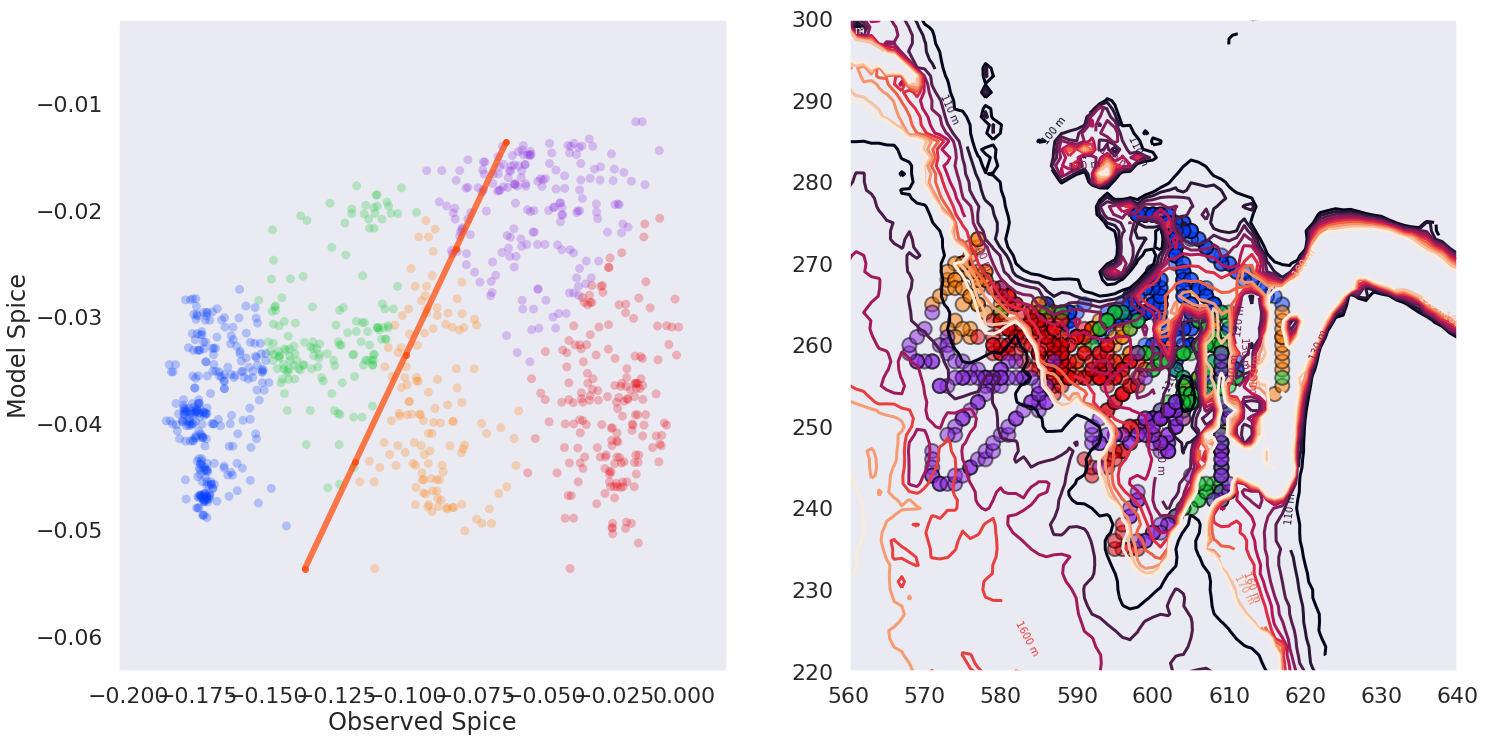

In [29]:
df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# >>> def func(x, a, b, c):
# #     return a * np.exp(-b * x) + c

# calculate polynomial
z = np.polyfit(df['Model Spice'],df['Observed Spice'], 1)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.arange(np.min(df['Model Spice']), np.max(df['Model Spice']), 0.01)
y_new = f(x_new)

x_fit = df['Model Spice']
y_fit = f(x_fit)


df['Fitted Spice'] = y_fit




fig, (ax1,ax) = plt.subplots(1,2, figsize=(24,12))

# q = plot_clusters(df, cluster.KMeans, (), {'n_clusters':3})

labels, colors = plot_clusters(ax=ax1, data=df, algorithm=cluster.KMeans, args=(), kwds={'n_clusters':5})
colors = np.array(colors)
ax1.set_xlabel("Observed Spice")
ax1.set_ylabel("Model Spice")

ax1.plot(y_new, x_new, lw=6, c='orangered', marker='.', alpha=0.7)

# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Fitted Spice'])
# anchored_text = AnchoredText("Statistics with Fitted Line: Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0., 1.),
#                        bbox_transform=ax1.transAxes
#                        )
# ax1.add_artist(anchored_text)


# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0.32, 0.),
#                        bbox_transform=ax1.transAxes
#                        )
# ax1.add_artist(anchored_text)

# ax.axhline(y=-0.055, c = 'teal')
# ax.axvline(x= -0.17, c = 'teal')

# ax.axhline(y=-0.037, c = 'red')


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# cmap = plt.get_cmap('deep')
# cmap = sns.color_palette('bright', np.unique(labels).max() + 1)
#     cmap.set_bad('burlywood')
# cmap.set_bad('#8b7765')
# fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

# for i in np.arange(x_added_3.shape[0]):

#     ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



y_264_cluster_1 = y_added_1[labels == 0]
x_264_cluster_1 = x_added_1[labels == 0]

y_264_cluster_2 = y_added_1[labels == 1]
x_264_cluster_2 = x_added_1[labels == 1]

y_264_cluster_3 = y_added_1[labels == 2]
x_264_cluster_3 = x_added_1[labels == 2]

y_264_cluster_4 = y_added_1[labels == 3]
x_264_cluster_4 = x_added_1[labels == 3]

y_264_cluster_5 = y_added_1[labels == 4]
x_264_cluster_5 = x_added_1[labels == 4]


for i in np.arange(x_264_cluster_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_1[i])], y_wcvi_slice[np.int(y_264_cluster_1[i])], c = colors[labels == 0], alpha= 0.5, s=200, edgecolor= 'black', label = 'cluster 1')

for i in np.arange(x_264_cluster_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_2[i])], y_wcvi_slice[np.int(y_264_cluster_2[i])], c = colors[labels == 1], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 2')

for i in np.arange(x_264_cluster_3.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_3[i])], y_wcvi_slice[np.int(y_264_cluster_3[i])], c = colors[labels == 2], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 3')

for i in np.arange(x_264_cluster_4.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_4[i])], y_wcvi_slice[np.int(y_264_cluster_4[i])], c = colors[labels == 3], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 4')

for i in np.arange(x_264_cluster_5.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_5[i])], y_wcvi_slice[np.int(y_264_cluster_5[i])], c = colors[labels == 4], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 5')

ax.set_ylim(220,300)
ax.set_xlim(560,640)


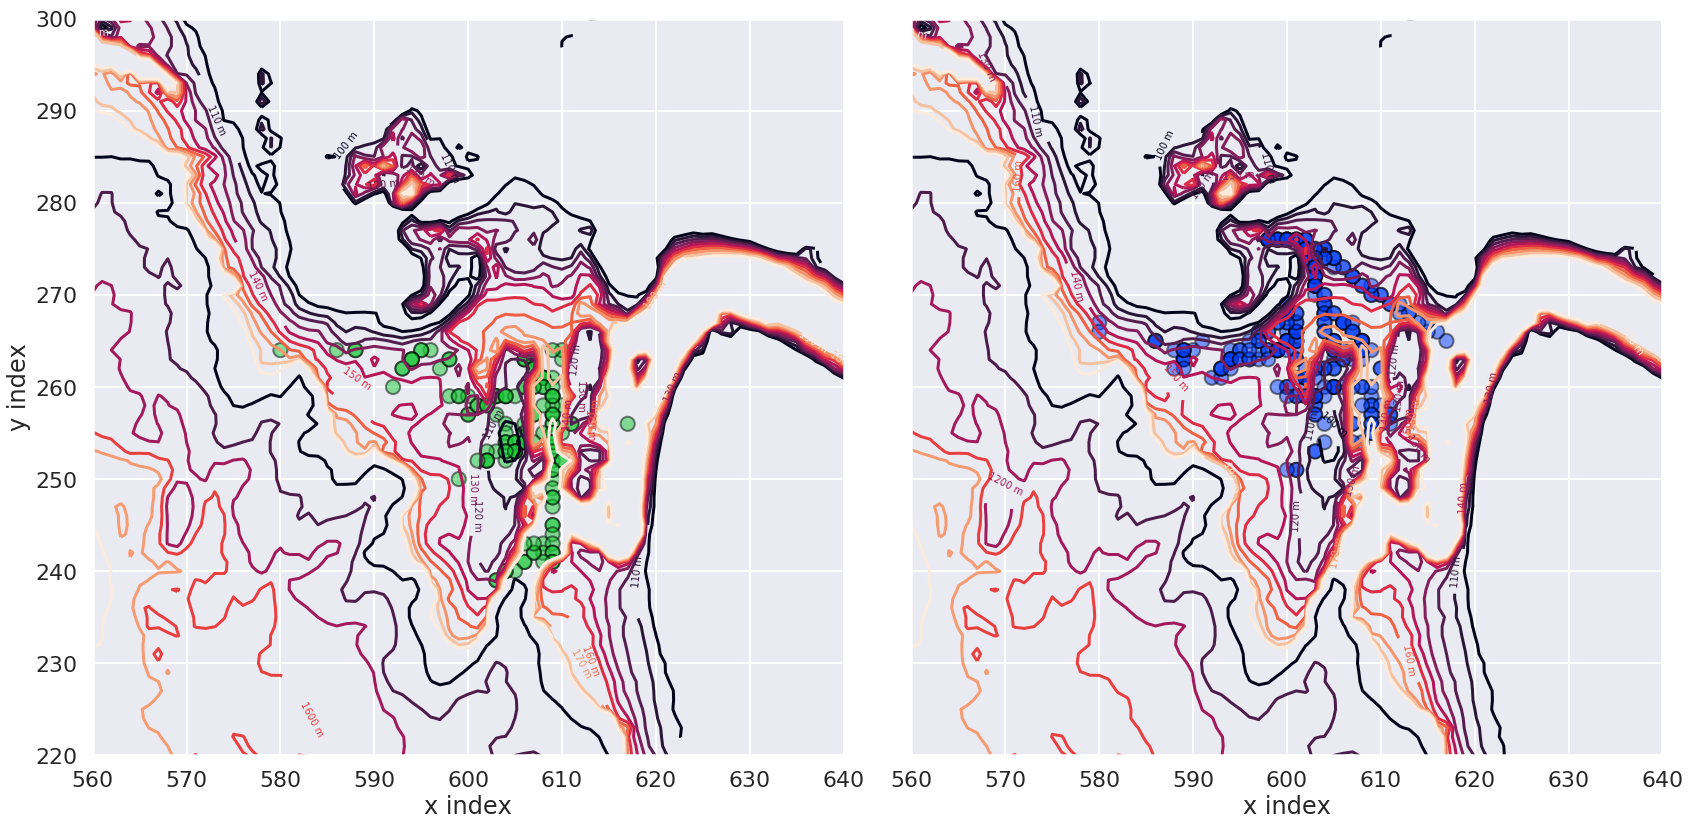

In [32]:


fig, (ax1,ax) = plt.subplots(1,2, figsize=(24,12), sharey=True)




bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))

CS = ax1.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax1.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)




for i in np.arange(x_264_cluster_3.shape[0]):

    ax1.scatter(x_wcvi_slice[np.int(x_264_cluster_3[i])], y_wcvi_slice[np.int(y_264_cluster_3[i])], c = colors[labels == 2], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 5')


ax1.set_ylim(220,300)
ax1.set_xlim(560,640)

ax1.set_ylabel('y index')
ax1.set_xlabel('x index')

ax1.grid()


CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)




for i in np.arange(x_264_cluster_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_1[i])], y_wcvi_slice[np.int(y_264_cluster_1[i])], c = colors[labels == 0], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 2')


ax.set_ylim(220,300)
ax.set_xlim(560,640)

ax.set_xlabel('x index')
ax.grid()

fig.tight_layout()


### Note for this isopycnal wrong is not necesarily wrong

In [33]:
model_right_cluster_x = x_264_cluster_1
model_right_cluster_y = y_264_cluster_1


model_wrong_cluster_x = x_264_cluster_3
model_wrong_cluster_y = y_264_cluster_3

In [34]:
rho_0 = 26.5
rho_intialising = rho[119,...] ##we initialise at this time step 26th August 120th day


z_intialising_right, z_intialising_wrong, model_x_right, model_y_right, model_x_wrong, model_y_wrong = \
get_z_indices_for_the_isopycnal_points(model_right_cluster_x=model_right_cluster_x, model_right_cluster_y=model_right_cluster_y,rho_0=rho_0,\
                                       rho_intialising=rho_intialising,model_wrong_cluster_x=model_wrong_cluster_x, \
                                       model_wrong_cluster_y = model_wrong_cluster_y)

In [35]:
init_file = pd.read_csv('/ocean/ssahu/CANYONS/ariane/ariane-2.2.8_04/initial_positions_LB08.txt', delimiter= ' ', header=None)

df =pd.DataFrame(data=init_file)
df = df.iloc[df.shape[0]:]
       
for p in np.arange(model_y_right.shape[0]):
    
    df = df.append({0:model_x_right[p]+1+0.01,1:model_y_right[p]+1+0.01,2:z_intialising_right[p]+1, 3:119.5, 4:1.0}, ignore_index=True)

df.to_csv('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/isopyncal_265/\
right_positions_iso_265.txt',
          sep = ' ', header = None, index=False)

df =pd.DataFrame(data=init_file)
df = df.iloc[df.shape[0]:]
       
for p in np.arange(model_y_wrong.shape[0]):
    
    df = df.append({0:model_x_wrong[p]+1+0.01,1:model_y_wrong[p]+1+0.01,2:z_intialising_wrong[p]+1, 3:119.5, 4:1.0}, ignore_index=True)

df.to_csv('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/isopyncal_265/\
wrong_positions_iso_265.txt',
          sep = ' ', header = None, index=False)

In [42]:
265-180

85

np.logical_not(sal_tzyx)

### Isopycnal 26.3 to all down for the true positive cluster points (right ones)

In [12]:
model_spic = []
survey_iso_spic = []

survey_iso_spic_A, model_spic_A = add_model_MVP_data(survey_file=survey_mat_file_A, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_B, model_spic_B = add_model_MVP_data(survey_file=survey_mat_file_B, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_D, model_spic_D = add_model_MVP_data(survey_file=survey_mat_file_D, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_E, model_spic_E = add_model_MVP_data(survey_file=survey_mat_file_E, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_G, model_spic_G = add_model_MVP_data(survey_file=survey_mat_file_G, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)


    
    
model_spic = []
survey_iso_spic = []

y_added_1 = []
x_added_1 = []


for survey_file in all_surveys:
    survey_iso_spic, model_spic, y_added_1, x_added_1 \
    = calcuate_location_of_kde_custers_kmeans_5(survey_file=survey_file, \
                                                iso_level=3,model_spic=model_spic, \
                                                survey_iso_spic=survey_iso_spic,\
                                                y_added_1=y_added_1,x_added_1=x_added_1)


(560, 640)

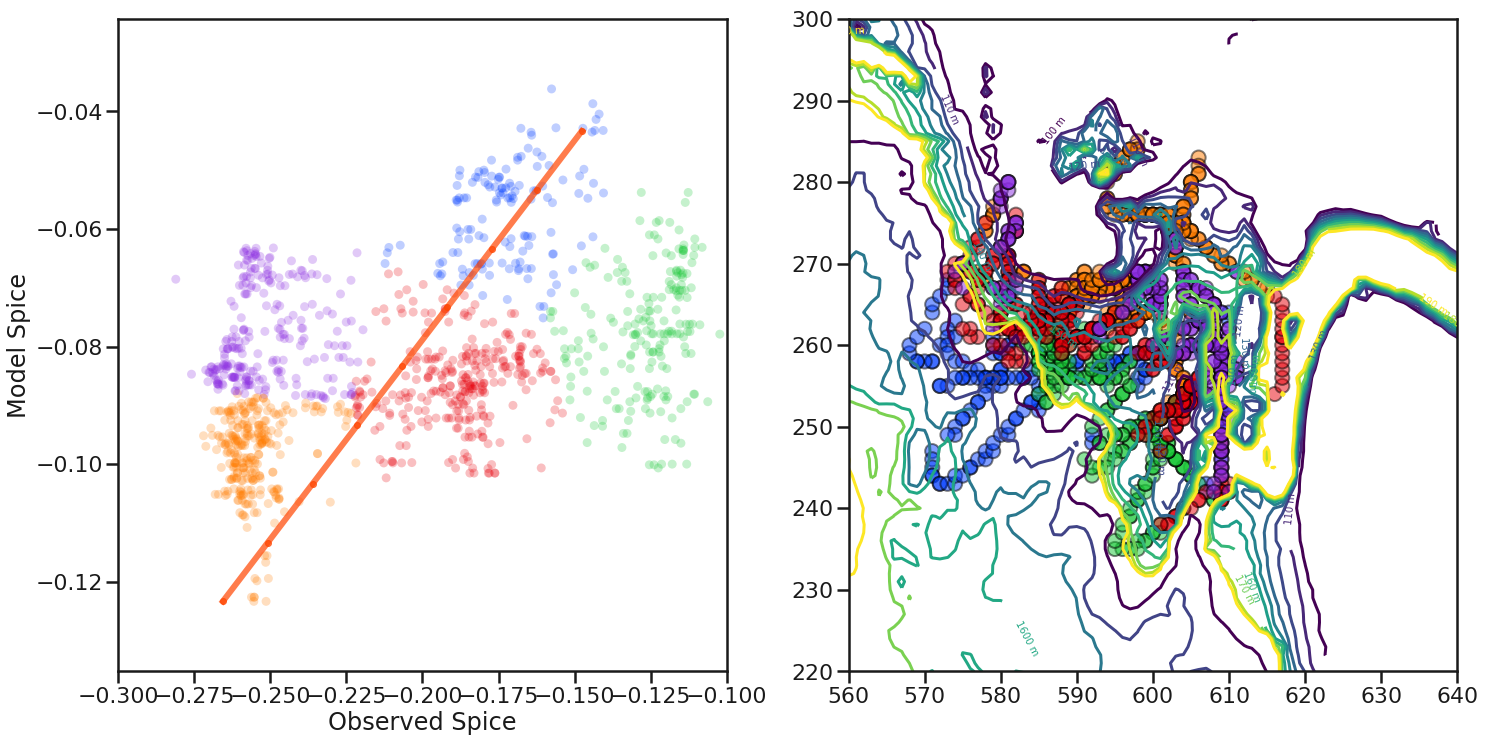

In [16]:
df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# >>> def func(x, a, b, c):
# #     return a * np.exp(-b * x) + c

# calculate polynomial
z = np.polyfit(df['Model Spice'],df['Observed Spice'], 1)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.arange(np.min(df['Model Spice']), np.max(df['Model Spice']), 0.01)
y_new = f(x_new)

x_fit = df['Model Spice']
y_fit = f(x_fit)


df['Fitted Spice'] = y_fit




fig, (ax1,ax) = plt.subplots(1,2, figsize=(24,12))

# q = plot_clusters(df, cluster.KMeans, (), {'n_clusters':3})

labels, colors = plot_clusters(ax=ax1, data=df, algorithm=cluster.KMeans, args=(), kwds={'n_clusters':5})
colors = np.array(colors)
ax1.set_xlabel("Observed Spice")
ax1.set_ylabel("Model Spice")

ax1.plot(y_new, x_new, lw=6, c='orangered', marker='.', alpha=0.7)
ax1.set_xlim(-0.3,-0.1)

# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Fitted Spice'])
# anchored_text = AnchoredText("Statistics with Fitted Line: Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0., 1.),
#                        bbox_transform=ax1.transAxes
#                        )
# ax1.add_artist(anchored_text)


# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0.32, 0.),
#                        bbox_transform=ax1.transAxes
#                        )
# ax1.add_artist(anchored_text)

# ax.axhline(y=-0.055, c = 'teal')
# ax.axvline(x= -0.17, c = 'teal')

# ax.axhline(y=-0.037, c = 'red')


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# cmap = plt.get_cmap('deep')
# cmap = sns.color_palette('bright', np.unique(labels).max() + 1)
#     cmap.set_bad('burlywood')
# cmap.set_bad('#8b7765')
# fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

# for i in np.arange(x_added_3.shape[0]):

#     ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



y_264_cluster_1 = y_added_1[labels == 0]
x_264_cluster_1 = x_added_1[labels == 0]

y_264_cluster_2 = y_added_1[labels == 1]
x_264_cluster_2 = x_added_1[labels == 1]

y_264_cluster_3 = y_added_1[labels == 2]
x_264_cluster_3 = x_added_1[labels == 2]

y_264_cluster_4 = y_added_1[labels == 3]
x_264_cluster_4 = x_added_1[labels == 3]

y_264_cluster_5 = y_added_1[labels == 4]
x_264_cluster_5 = x_added_1[labels == 4]


for i in np.arange(x_264_cluster_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_1[i])], y_wcvi_slice[np.int(y_264_cluster_1[i])], c = colors[labels == 0], alpha= 0.5, s=200, edgecolor= 'black', label = 'cluster 1')

for i in np.arange(x_264_cluster_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_2[i])], y_wcvi_slice[np.int(y_264_cluster_2[i])], c = colors[labels == 1], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 2')

for i in np.arange(x_264_cluster_3.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_3[i])], y_wcvi_slice[np.int(y_264_cluster_3[i])], c = colors[labels == 2], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 3')

for i in np.arange(x_264_cluster_4.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_4[i])], y_wcvi_slice[np.int(y_264_cluster_4[i])], c = colors[labels == 3], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 4')

for i in np.arange(x_264_cluster_5.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_5[i])], y_wcvi_slice[np.int(y_264_cluster_5[i])], c = colors[labels == 4], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 5')

ax.set_ylim(220,300)
ax.set_xlim(560,640)


In [17]:
sns.set_style('darkgrid')

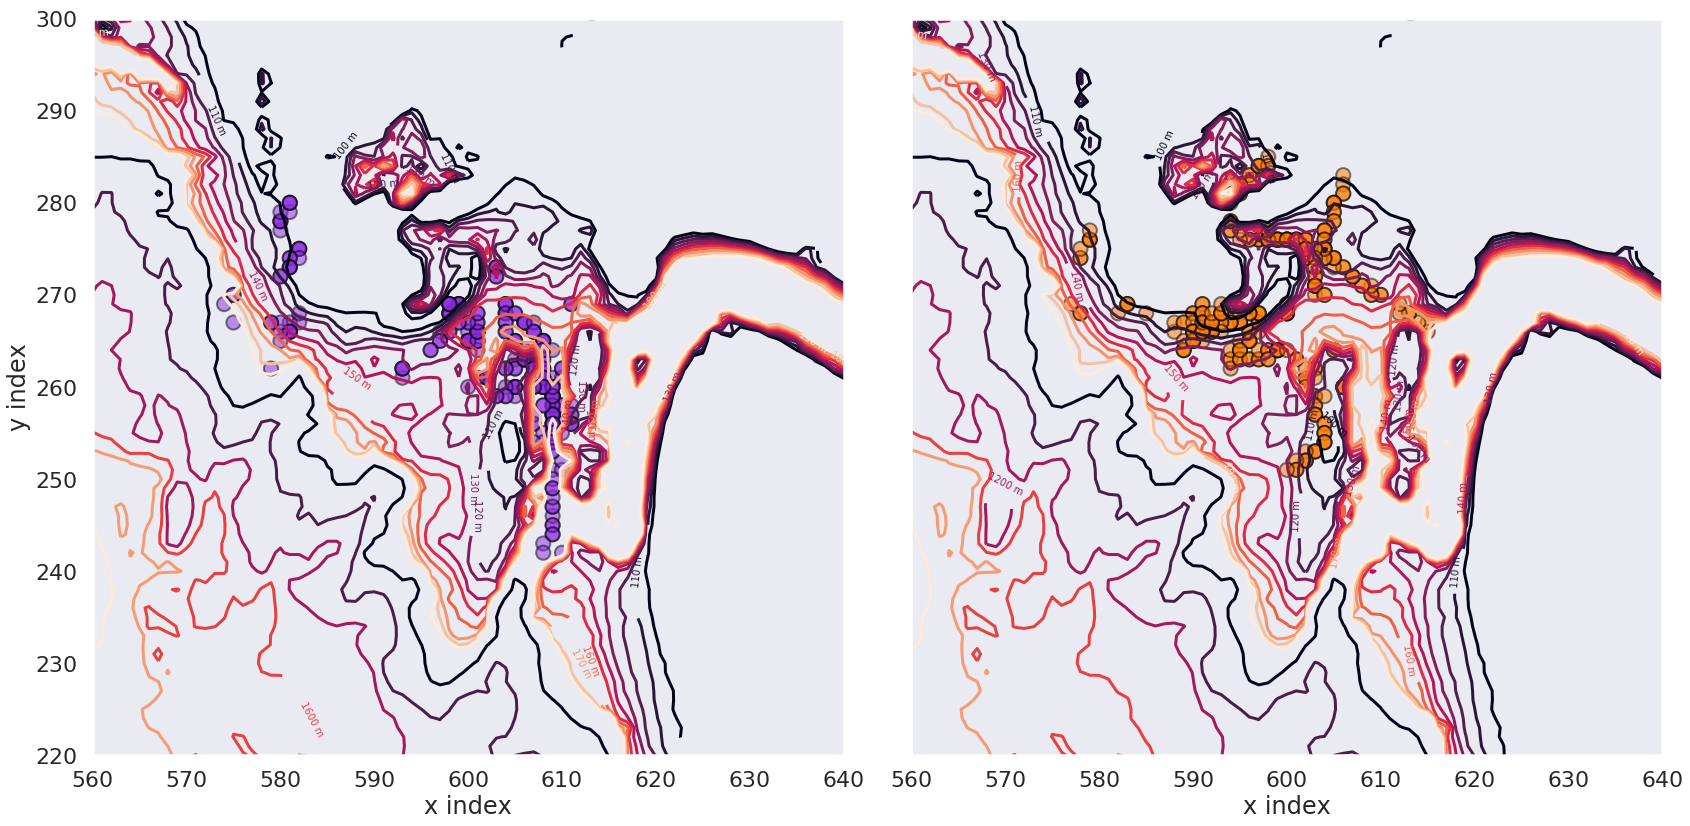

In [18]:


fig, (ax1,ax) = plt.subplots(1,2, figsize=(24,12), sharey=True)




bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))

CS = ax1.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax1.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)




for i in np.arange(x_264_cluster_5.shape[0]):

    ax1.scatter(x_wcvi_slice[np.int(x_264_cluster_5[i])], y_wcvi_slice[np.int(y_264_cluster_5[i])], c = colors[labels == 4], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 5')


ax1.set_ylim(220,300)
ax1.set_xlim(560,640)

ax1.set_ylabel('y index')
ax1.set_xlabel('x index')

ax1.grid()


CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)




for i in np.arange(x_264_cluster_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_2[i])], y_wcvi_slice[np.int(y_264_cluster_2[i])], c = colors[labels == 1], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 2')


ax.set_ylim(220,300)
ax.set_xlim(560,640)

ax.set_xlabel('x index')
ax.grid()

fig.tight_layout()


In [19]:
model_right_cluster_x = x_264_cluster_2
model_right_cluster_y = y_264_cluster_2


model_wrong_cluster_x = x_264_cluster_5
model_wrong_cluster_y = y_264_cluster_5

In [20]:
rho_0 = 26.3
rho_intialising = rho[119,...] ##we initialise at this time step 26th August 120th day


z_intialising_right, z_intialising_wrong, model_x_right, model_y_right, model_x_wrong, model_y_wrong = get_z_indices_for_the_isopycnal_points(model_right_cluster_x=model_right_cluster_x, model_right_cluster_y=model_right_cluster_y,rho_0=rho_0,\
                                       rho_intialising=rho_intialising,model_wrong_cluster_x=model_wrong_cluster_x, \
                                       model_wrong_cluster_y = model_wrong_cluster_y)

In [26]:
mesh_mask_large  = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask   = mesh_mask_large.variables['tmask'][:,:32,180:350,480:650]

In [28]:
p = 0

np.max(np.nonzero(tmask[0,:,model_y_right[p].astype(int),model_x_right[p].astype(int)]))

21

In [29]:
z_intialising_right[p]

20.0

In [35]:
init_file = pd.read_csv('/ocean/ssahu/CANYONS/ariane/ariane-2.2.8_04/initial_positions_LB08.txt', delimiter= ' ', header=None)

df =pd.DataFrame(data=init_file)
df = df.iloc[df.shape[0]:]
       
for p in np.arange(model_y_right.shape[0]):
    
    min_ind_z = z_intialising_right[p].astype(int)
    max_ind_z = np.max(np.nonzero(tmask[0,:,model_y_right[p].astype(int),model_x_right[p].astype(int)]))
    for q in np.arange(min_ind_z, max_ind_z):
    
        df = df.append({0:model_x_right[p]+1+0.01,1:model_y_right[p]+1+0.01,2:q+1, 3:119.5, 4:1.0}, ignore_index=True)

df.to_csv('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/isopyncal_263/\
right_positions_iso_263_full_down.txt',
          sep = ' ', header = None, index=False)


In [36]:
df.shape

(1180, 5)

In [25]:
z_intialising_right.shape

(245,)

In [23]:
x_wcvi_slice

array([480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492,
       493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505,
       506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518,
       519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531,
       532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544,
       545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557,
       558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583,
       584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596,
       597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609,
       610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622,
       623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635,
       636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649])